In [ ]:
!pip install pmdarima

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import os

sns.set()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.0 MB/s eta 0:00:00


In [ ]:
print("Current working directory: " , os.getcwd())
print("Files in current directory: ", os.listdir(os.getcwd()))
os.makedirs("/content/data", exist_ok=True)

Current working directory:  /content
Files in current directory:  ['.config', 'sample_data']


In [ ]:
from google.colab import files
# Upload csv files to cwd
uploaded = files.upload()
os.makedirs("/content/data", exist_ok=True)

In [ ]:
import shutil
for filename in uploaded.keys():
  shutil.move(f"/content/{filename}", f"/content/data/{filename}")
  print(f"{filename} moved to data folder.")

In [ ]:
# Building the data frame

dfs = []
#csv_file = "mentalHealthSupport.csv"

for filename in os.listdir("/content/data"):
  #filename = os.path.join(os.getcwd(), "data", csv_file)
  column_name = filename.replace("_"," ").replace(".csv", "").capitalize() + " Searches"
  file_path = os.path.join("/content/data", filename)

  df = pd.read_csv(file_path, header=None, names=['Week', column_name], parse_dates=['Week'])

  df = df.loc[df['Week'] < '2024-01-09']
  df = df.iloc[1:]
  df.reset_index(drop=True, inplace=True)

  # Replace missing values to NaN
  df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
  df.set_index('Week', inplace=True)

  # Append df to dfs list
  dfs.append(df)

print(dfs[0].head())
dfs_merge = pd.concat(dfs, axis=1)

print(dfs_merge)


            Seasonaldepression Searches
Week                                   
2021-01-03                           31
2021-01-10                           34
2021-01-17                           28
2021-01-24                           34
2021-01-31                           31
            Seasonaldepression Searches  Depressionsupportgroup Searches  \
Week                                                                       
2021-01-03                           31                               72   
2021-01-10                           34                               41   
2021-01-17                           28                               31   
2021-01-24                           34                               66   
2021-01-31                           31                               46   
...                                 ...                              ...   
2023-12-03                           78                               71   
2023-12-10                          

<ipython-input-11-76bc7a79f5cd>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, header=None, names=['Week', column_name], parse_dates=['Week'])
<ipython-input-11-76bc7a79f5cd>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, header=None, names=['Week', column_name], parse_dates=['Week'])
<ipython-input-11-76bc7a79f5cd>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, header=None, names=['Week', column_name], parse_dates=['Week'])
<ipython-input-11-76bc7a79f5cd>:11: UserWarning: Could not

In [ ]:
# Handling missing data
print(dfs_merge.isnull().sum)
print(dfs_merge[dfs_merge[column_name].isnull()])

# Handle missing data by replacing NaN rows withe the next valid value (test)
# Backward fill is more optimal when there are dips in search activity
dfs_merge[column_name].fillna(method= 'ffill', inplace=True)

# Replace missing values with mean
#df[column_name].fillna(df[column_name].mean(), inplace=True)

# Incase backward fill does not work, just drop NaN values
#df.dropna(subset=[column_name], inplace=True)


<bound method DataFrame.sum of             Seasonaldepression Searches  Depressionsupportgroup Searches  \
Week                                                                       
2021-01-03                        False                            False   
2021-01-10                        False                            False   
2021-01-17                        False                            False   
2021-01-24                        False                            False   
2021-01-31                        False                            False   
...                                 ...                              ...   
2023-12-03                        False                            False   
2023-12-10                        False                            False   
2023-12-17                        False                            False   
2023-12-24                        False                            False   
2023-12-31                        False                  

<ipython-input-12-03863aeccfaf>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfs_merge[column_name].fillna(method= 'ffill', inplace=True)
<ipython-input-12-03863aeccfaf>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfs_merge[column_name].fillna(method= 'ffill', inplace=True)


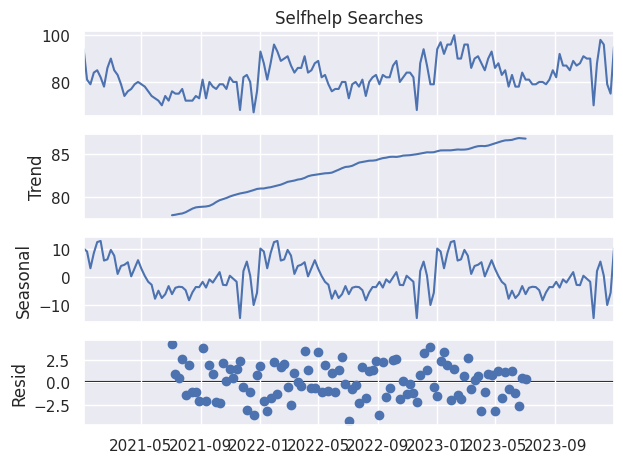

In [ ]:
# Handeling Outliers
from statsmodels.tsa.seasonal import seasonal_decompose
# Section data into seasonal, trend, and residual components
decomp = seasonal_decompose(dfs_merge[column_name], model= 'additive', period=52)
decomp.plot()

# Filter out the seasonal trends and remove residual outliers
# Change number of days
dfs_merge['rolling_mean']= dfs_merge[column_name].rolling(window=3).mean()


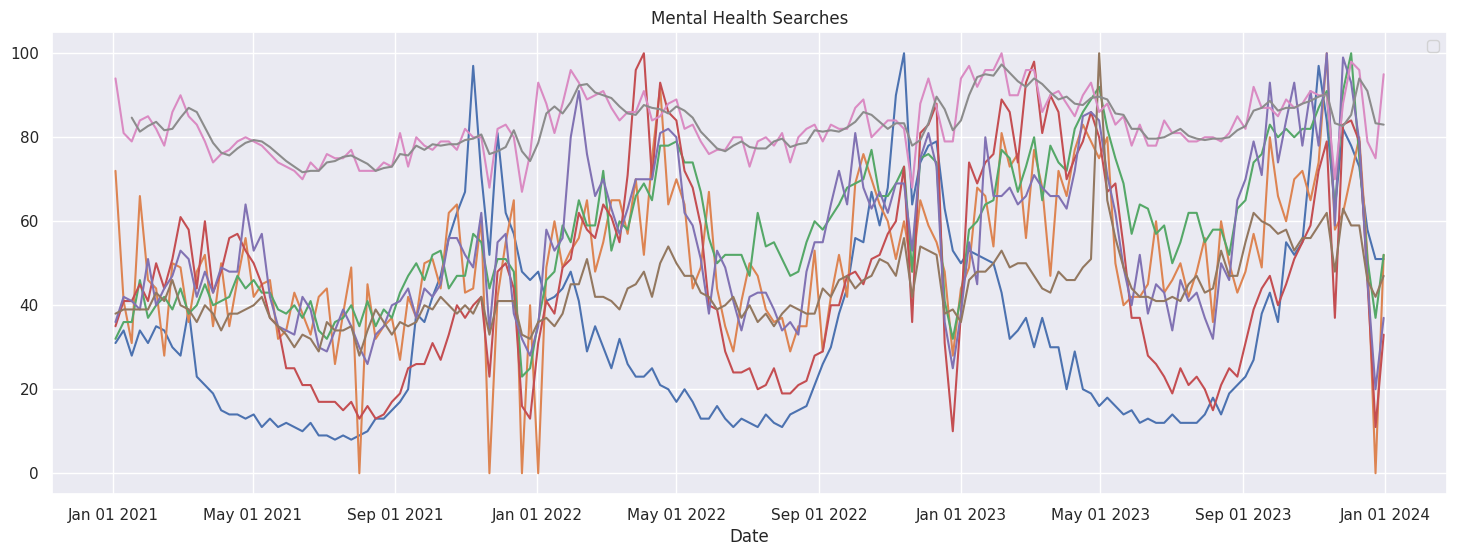

In [ ]:
# Plot time series
import matplotlib.dates as mdates

dfs_merge.index = pd.to_datetime(dfs_merge.index, errors='coerce')
plt.figure(figsize=(18, 6))
plt.plot(dfs_merge)
plt.title('Mental Health Searches')
plt.xlabel('Date')
#plt.ylabel()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
plt.legend()
plt.show()

In [ ]:
# Find the weights of each term
# This approach ensure that the features with higher relevance impact the forecast more
weight = dfs_merge.mean() / dfs_merge.mean().sum()
print("Total weight for each term:\n", weight)

# Aggregate search term with weight
dfs_merge['Weighted Sum'] = dfs_merge.mul(weight, axis=1).sum(axis=1)

Total weight for each term:
 Seasonaldepression Searches        0.065865
Depressionsupportgroup Searches    0.099473
Mentalhealthsupport Searches       0.111526
Causesofdepression Searches        0.089947
Negativethinking Searches          0.106893
Loneliness Searches                0.085326
Selfhelp Searches                  0.161002
rolling_mean                       0.160846
Weighted Sum                       0.119122
dtype: float64


In [ ]:
print(dfs_merge['Weighted Sum'].head())
print(dfs_merge.index)

Week
2021-01-03    43.304032
2021-01-10    39.595662
2021-01-17    52.990815
2021-01-24    59.128845
2021-01-31    56.980543
Name: Weighted Sum, dtype: float64
DatetimeIndex(['2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',
               '2021-02-28', '2021-03-07',
               ...
               '2023-10-29', '2023-11-05', '2023-11-12', '2023-11-19',
               '2023-11-26', '2023-12-03', '2023-12-10', '2023-12-17',
               '2023-12-24', '2023-12-31'],
              dtype='datetime64[ns]', name='Week', length=157, freq=None)


In [ ]:
# ADF test for stationarity
result = adfuller(dfs_merge['Weighted Sum'])
print(f'ADF Statistic: {result[0]}') # the more negative this value, the stronger the evidence that the time series is stationary
print(f'p-value: {result[1]}') # if the p-value is below a threshold (typically 0.05), it suggests that the time series is stationary

#If time series is not stationary, need to differenciate or use other transformations

ADF Statistic: -2.9826156199079388
p-value: 0.03655008599721432


In [ ]:
# Use auto_arima to find optimal params, auto_arima chooses best sarima model

## WARNING: This cell may take a while to run (approx time: 5-10m)

stepwise_model = auto_arima(dfs_merge['Weighted Sum'], seasonal=True, m=52, trace=True) # m=52 in order to make the model week based
print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=73.22 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=621.938, Time=1.44 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=603.454, Time=4.40 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=596.493, Time=2.69 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=596.842, Time=0.72 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=25.74 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=598.468, Time=26.85 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=596.484, Time=2.38 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=598.468, Time=23.06 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=600.468, Time=26.09 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=622.711, Time=4.58 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=597.409, Time=4.57 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=597.799, Time=3.70 sec
 ARIMA(1,1,2)(1,1,0)[52]             : AIC=597.412, Time=13.66 sec
 ARIMA(0,1,1)(1,1,0)[52] intercept 

In [ ]:
sarima_model = SARIMAX(dfs_merge['Weighted Sum'],
                       order=stepwise_model.order,  # Optimal ARIMA order from auto_arima
                       seasonal_order=stepwise_model.seasonal_order, # optimal ARIMA seasonal order from auto_arima
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


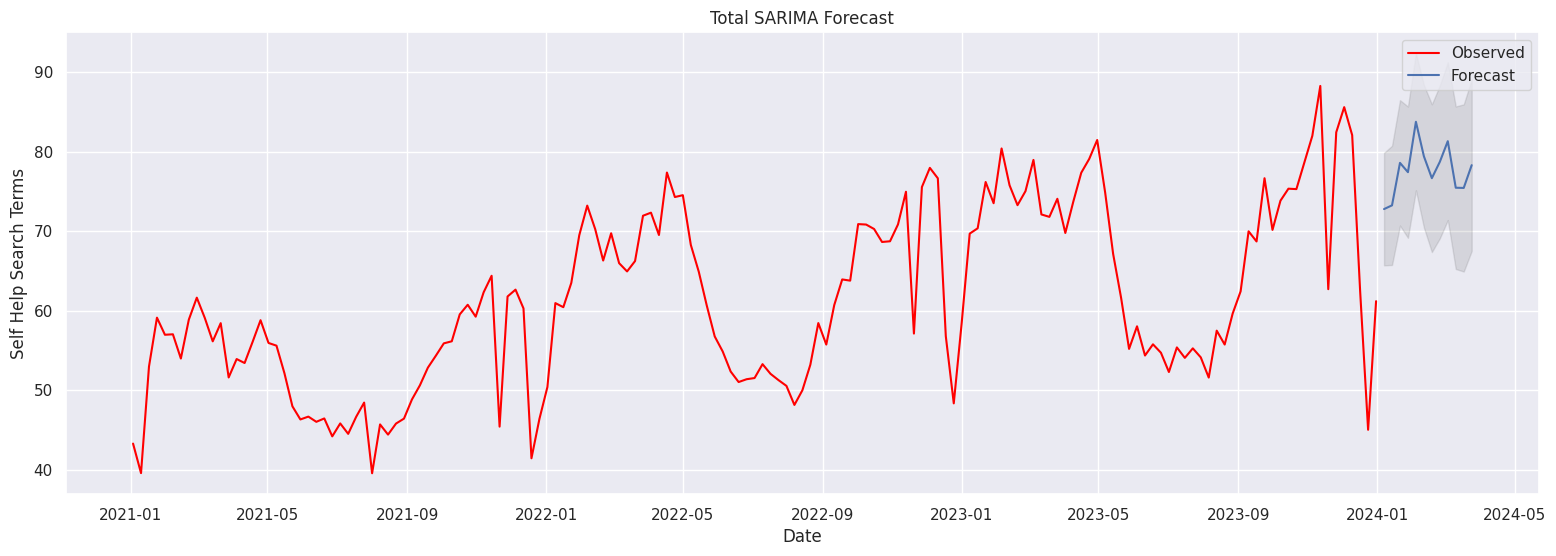

In [ ]:
#predictions
# Forecast for the next 12 months
forecast = sarima_result.get_forecast(steps=12)

# Get confidence intervals
forecast_ci = forecast.conf_int()
forecast_ci.index = pd.to_datetime(forecast_ci.index)
# Plot the forecast
plt.figure(figsize=(19, 6))
plt.plot(dfs_merge.index, dfs_merge['Weighted Sum'], label='Observed', color='red')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.1)
plt.title('Total SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Self Help Search Terms')
plt.legend()
plt.show()

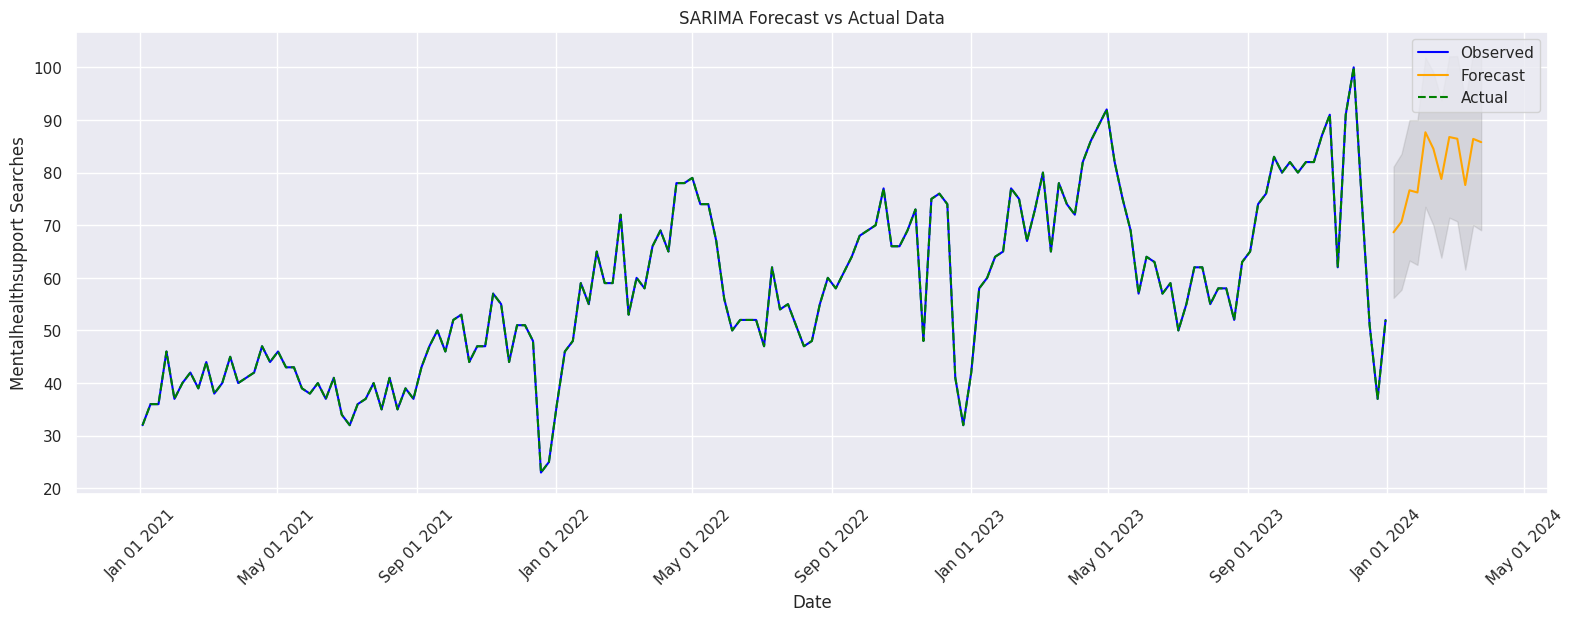

In [ ]:
# Ensure forecast index is properly formatted
forecast.predicted_mean.index = pd.to_datetime(forecast.predicted_mean.index, errors='coerce')
forecast_ci.index = pd.to_datetime(forecast_ci.index, errors='coerce')

# Ensure the index of the actual data is also in datetime format
df.index = pd.to_datetime(df.index, errors='coerce')

# Plot the observed, forecast, and actual data
plt.figure(figsize=(19, 6))

# Plot the observed data (from your original df)
plt.plot(df.index, df[column_name], label='Observed', color='blue')

# Plot the forecasted data
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='orange')

# Plot the actual data from df_actual (overlayed on top of the forecast)
plt.plot(df.index, df[column_name], label='Actual', color='green', linestyle='--')

# Add confidence intervals for the forecast
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)

# Formatting the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
plt.xticks(rotation=45)

# Add titles and labels
plt.title('SARIMA Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel(column_name)

# Add the legend to distinguish between the observed, forecasted, and actual data
plt.legend()

# Show the plot
plt.show()